In [1]:
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

In [2]:
class MLP(nn.Module): 
    def __init__(self, in_features=75):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.head = nn.Linear(32, 2)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.act(x)
        x = self.head(x)
        return x

In [3]:
def train_epoch(model, optimizer, loss_fn, train_loader):
    model.train()
    losses = 0.
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x) 
        loss = loss_fn(output, y.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += loss.cpu().item()
    return losses/len(train_loader)

def validate(model, loss_fn, valid_loader):
    model.eval()
    losses = 0.
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_fn(output, y.flatten())

            losses += loss.cpu().item()
    return losses/len(valid_loader)

def get_model():    
    model = MLP(in_features=75)
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    return model, loss_fn, optimizer

def run_epoch(EPOCHS, train_loader, valid_loader, history_dict, fold_num):
    start = time.time()
    model, loss_fn, optimizer = get_model()

    loss_history, valid_history = [], []
    best_model, best_loss = None, float('inf')

    for i in range(EPOCHS):
        train_loss = train_epoch(model, optimizer, loss_fn, train_loader)
        valid_loss = validate(model, loss_fn, valid_loader)

        learning_rate = optimizer.param_groups[0]['lr']
        if best_loss > valid_loss:
            best_model, best_loss = deepcopy(model), valid_loss

        loss_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'epoch {i+1 :2d} train {train_loss :.4f} valid {valid_loss :.4f} lr {learning_rate :.4f} time {round(time.time() - start, 2)}s')
    history_dict[fold_num] = [best_model.cpu(), best_loss, loss_history, valid_history]
    return history_dict

In [4]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        try: len(y)
        except: y = [y]
        return torch.tensor(x).float(), torch.tensor(y).long()

In [5]:
def scaling(df, col, scaler=None):
    if scaler is None:
        scaler = StandardScaler().fit(df[col])
        df[col] = scaler.transform(df[col])
        return df, scaler
    df[col] = scaler.transform(df[col])
    return df

In [6]:
def get_clf_eval(y_actual, y_pred):
    print(f'acc: {accuracy_score(y_actual, y_pred) :.4f} '
          f'prec: {precision_score(y_actual, y_pred) :.4f} '
          f'rec: {recall_score(y_actual, y_pred) :.4f} '
          f'f1: {f1_score(y_actual, y_pred) :.4f} '
          f'ratio: {y_pred.sum() / len(y_pred) :.4f} ')   
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

In [7]:
df_train = pd.read_csv('train.csv')
len(df_train), df_train['depvar'].sum() / len(df_train)

(100000, 0.32569)

In [8]:
df = df_train.copy()
x_cols = df.drop(['depvar'], axis=1).columns.tolist()

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

x_train, scaler = scaling(df_train[x_cols].copy(), x_cols)
y_train = df_train['depvar']

x_test = scaling(df_test[x_cols].copy(), x_cols, scaler)
y_test = df_test['depvar']

in_features = len(x_cols)
in_features, len(x_train)

(75, 80000)

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)
len(x_train), len(x_valid), len(y_train), len(y_valid)

(64000, 16000, 64000, 16000)

In [10]:
batch_size = 512

train_set = CustomDataset(x_train.values, y_train.values)
valid_set = CustomDataset(x_valid.values, y_valid.values)

train_loader = DataLoader(train_set, batch_size=batch_size, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, pin_memory=True, drop_last=True)

In [11]:
epochs = 30

history_dict = run_epoch(epochs, train_loader, valid_loader, dict(), 0)

epoch  1 train 0.5833 valid 0.5496 lr 0.0010 time 2.09s
epoch  2 train 0.5426 valid 0.5423 lr 0.0010 time 5.48s
epoch  3 train 0.5357 valid 0.5349 lr 0.0010 time 9.11s
epoch  4 train 0.5287 valid 0.5280 lr 0.0010 time 12.83s
epoch  5 train 0.5238 valid 0.5243 lr 0.0010 time 16.86s
epoch  6 train 0.5208 valid 0.5218 lr 0.0010 time 20.77s
epoch  7 train 0.5184 valid 0.5194 lr 0.0010 time 24.56s
epoch  8 train 0.5162 valid 0.5176 lr 0.0010 time 28.43s
epoch  9 train 0.5144 valid 0.5162 lr 0.0010 time 33.57s
epoch 10 train 0.5128 valid 0.5150 lr 0.0010 time 37.68s
epoch 11 train 0.5114 valid 0.5141 lr 0.0010 time 41.4s
epoch 12 train 0.5102 valid 0.5131 lr 0.0010 time 43.16s
epoch 13 train 0.5091 valid 0.5121 lr 0.0010 time 44.85s
epoch 14 train 0.5080 valid 0.5113 lr 0.0010 time 46.62s
epoch 15 train 0.5071 valid 0.5107 lr 0.0010 time 48.41s
epoch 16 train 0.5062 valid 0.5102 lr 0.0010 time 50.08s
epoch 17 train 0.5052 valid 0.5096 lr 0.0010 time 51.91s
epoch 18 train 0.5044 valid 0.5092 

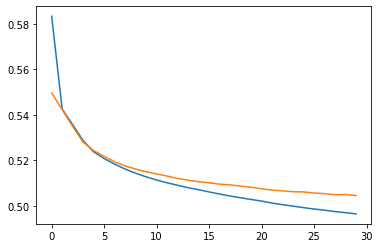

In [12]:
hd = deepcopy(history_dict)
plt.plot(hd[0][2])
plt.plot(hd[0][3])

acc: 0.7516 prec: 0.6592 rec: 0.5034 f1: 0.5709 ratio: 0.2507 


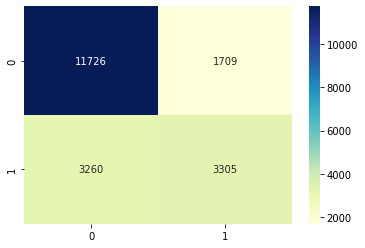

In [13]:
saved_model = hd[0][0].eval()
y_pred = saved_model(torch.FloatTensor(x_test.values)).argmax(-1).numpy()
get_clf_eval(y_test.values, y_pred)

In [14]:
# after training

In [15]:
def plot_learning_curve(fold_num, history_dict, row, col, fig_size=(30,10)):
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=fig_size)
    for j in range(col):
        ax[j].plot(history_dict[j][2])
        ax[j].plot(history_dict[j][3])
    plt.show()
    return

def inference(state_dict: dict, x_test: np.array, y_test: np.array = None):
    model = MLP()
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    logits = model(torch.FloatTensor(x_test).to(device))
    return logits

def get_stack_logits(fold_num, history_dict, x_test: np.array, y_test=None, show=False):
    stack_logits = torch.zeros(len(x_test), 2).to(device)
    for i in range(fold_num):
        logits = inference(history_dict[i][0], x_test)
        stack_logits += logits

    if y_test is not None and show:
        get_clf_eval(y_test, stack_logits.argmax(-1).cpu().numpy())
    return stack_logits

In [16]:
fold_num = 5
path = 'history.pt'
history_dict = torch.load(path)

In [17]:
scaler = history_dict['scaler']
x_cols = history_dict['x_cols']
x_test = pd.read_csv('test.csv')[x_cols]
x_test = scaling(x_test, x_cols, scaler)
submission = pd.read_csv('sample_submission.csv')

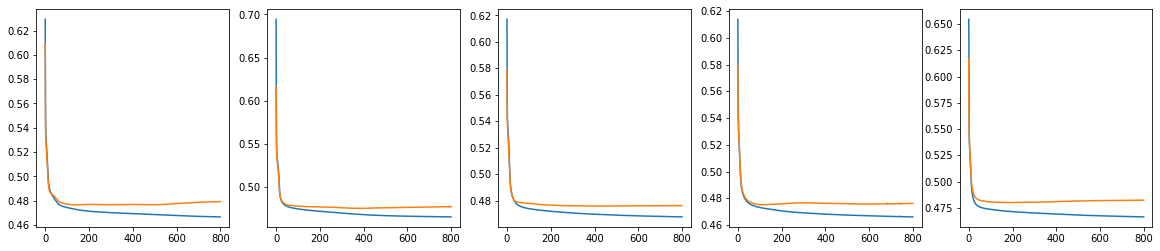

In [18]:
plot_learning_curve(fold_num, history_dict, 1, 5, (20, 4))

In [19]:
# prediction with vanila model
vanila_stack_logits = get_stack_logits(fold_num, history_dict, x_test.values)
vanila_submission = submission.copy()
vanila_pred = vanila_stack_logits.argmax(-1).numpy()
vanila_submission['answer'] = vanila_pred
vanila_submission.to_csv('_test_submission.csv', index=False)

print(f"vanila pred ratio: {vanila_pred.sum() / len(vanila_pred) :.4f}")
# vanila model public f1 score ~ 0.70

vanila pred ratio: 0.2614


In [20]:
df_data = pd.read_csv('train.csv')
x_train = df_data.drop(['depvar'], axis=1)
x_train = scaling(x_train, x_cols, scaler)
y_train = df_data['depvar']
train_stack_logits = get_stack_logits(fold_num, history_dict, x_train.values, y_train.values)

In [21]:
# train.csv model predictions
table = pd.concat([x_train, y_train], axis=1)
table['pred'] = train_stack_logits.argmax(-1).numpy()
table['correct'] = (table.depvar == table.pred).astype('int')
len(table), table['pred'].sum()/len(table)

(100000, 0.25774)

In [22]:
# reverse calculation based on the public f1 score
target_acc_sampling_number = 7000 # roughly calculated
samples = random.sample(table[table['correct'] == 0].index.tolist(), target_acc_sampling_number) 
table = table.drop(samples, axis=0)

print(f"adjusted acc: {table['correct'].sum() / len(table) :.4f}")
print(f"adjusted ratio: {table['pred'].sum() / len(table) :.4f}")

x_train_adj = table[x_cols]
y_train_adj = table['depvar']
len(x_train_adj)

adjusted acc: 0.8218
adjusted ratio: 0.2499


93000

acc: 0.8221 prec: 0.7463 rec: 0.6191 f1: 0.6767 ratio: 0.2495 


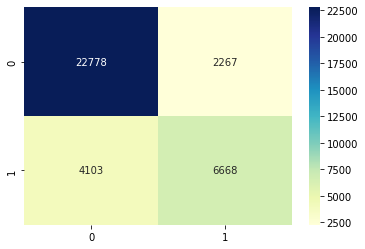

In [23]:
n_sample = len(pd.read_csv('test.csv'))

x_sample = x_train_adj.sample(n=n_sample, random_state=0)
y_sample = y_train_adj.sample(n=n_sample, random_state=0)

sample_stack_logits = get_stack_logits(fold_num, history_dict, x_sample.values, y_sample.values, show=True)

In [24]:
def find_best_threshold(logits, real, start, end, step, ratio_list):
    visited, ratio_log, f1_log, th_log = np.array([]), np.array([]), np.array([]), np.array([])
    
    for threshold in tqdm(np.arange(start, end, step)):
        
        pred = logits.softmax(-1)[:, 1].cpu() > threshold
        tf_ratio = round((pred.sum() / len(pred)).item(), 4)

        if (tf_ratio in ratio_list) and (tf_ratio not in visited):
            f1 = f1_score(real, pred)
                
            f1_log = np.append(f1_log, f1)
            th_log = np.append(th_log, threshold)
            ratio_log = np.append(ratio_log, tf_ratio)

            visited = np.append(visited, tf_ratio)
        
    return ratio_log, f1_log, th_log

100%|██████████| 1000/1000 [00:17<00:00, 56.48it/s]


threshold 0.1460 f1 0.689, tested ratio 665


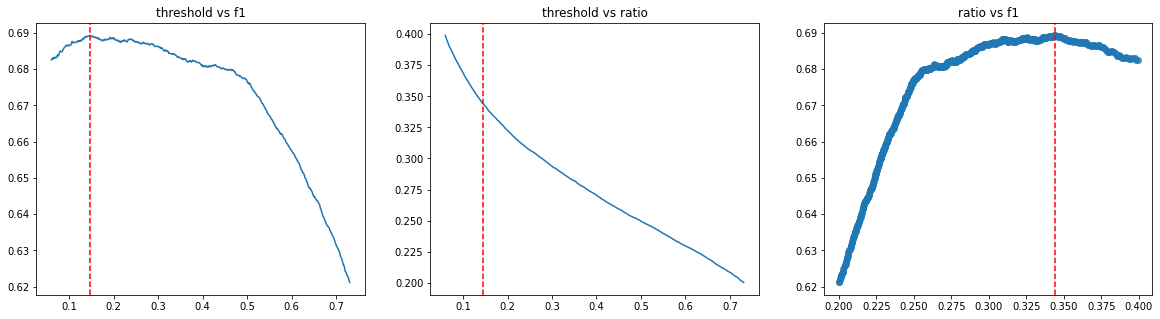

100%|██████████| 1000/1000 [00:19<00:00, 51.72it/s]


threshold 0.1630 f1 0.690, tested ratio 668


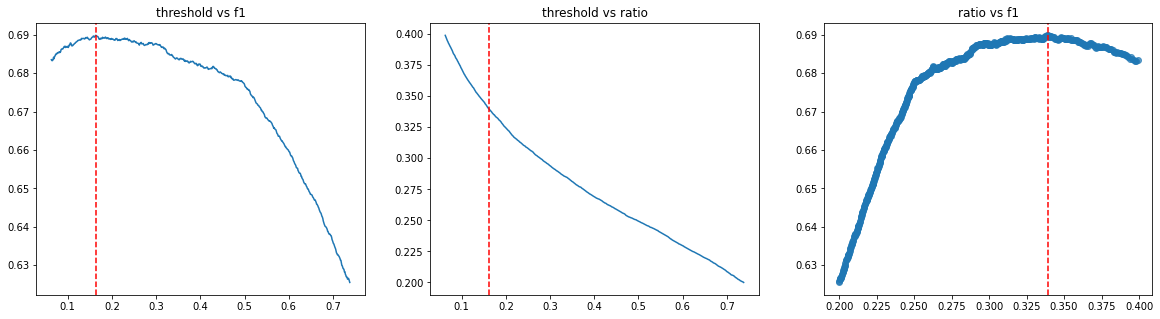

100%|██████████| 1000/1000 [00:18<00:00, 54.91it/s]


threshold 0.1360 f1 0.687, tested ratio 667


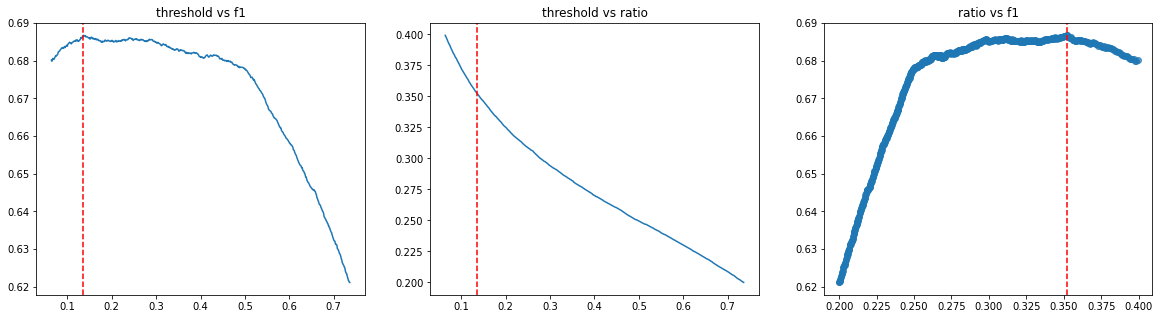

100%|██████████| 1000/1000 [00:18<00:00, 54.43it/s]


threshold 0.2660 f1 0.690, tested ratio 676


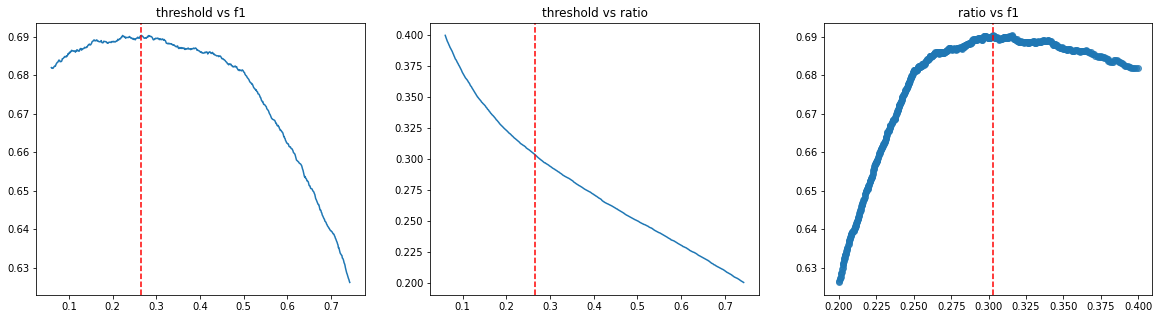

100%|██████████| 1000/1000 [00:17<00:00, 56.61it/s]


threshold 0.2230 f1 0.691, tested ratio 674


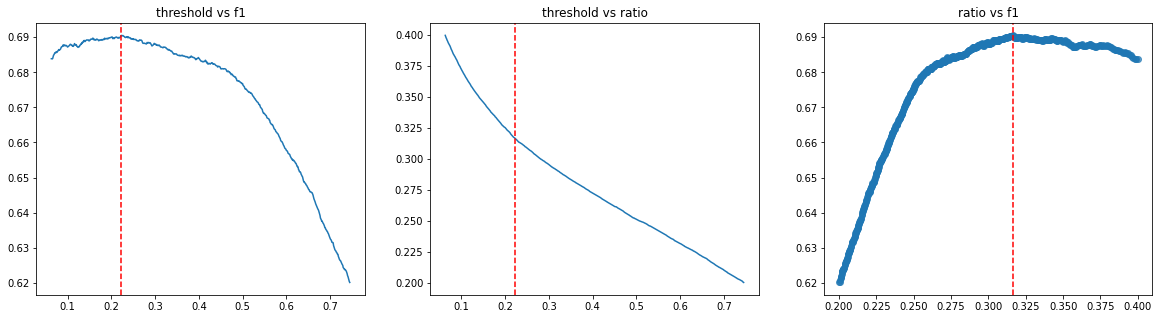

In [25]:
def sample_seed(x_df, y_df, n_sample, seed, fold, history, s=0, e=1, sp=0.001, ratio_list=np.arange(0.2, 0.4, 0.001)):
    _x_sample = x_df.sample(n=n_sample, random_state=seed)
    _y_sample = y_df.sample(n=n_sample, random_state=seed)

    _sample_stack_logits = get_stack_logits(fold, history, _x_sample.values, _y_sample.values)
    _ratio_log, _f1_log, _th_log   = find_best_threshold(_sample_stack_logits, _y_sample.values, s, e, sp, ratio_list)

    best_f1 = max(_f1_log)
    best_index = np.where(_f1_log == best_f1)[0][0]
    best_ratio = _ratio_log[best_index]    
    best_th = _th_log[best_index]

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    ax[0].plot(_th_log, _f1_log)
    ax[0].axvline(best_th, color='r', linestyle='--')

    ax[1].plot(_th_log, _ratio_log)
    ax[1].axvline(best_th, color='r', linestyle='--')

    ax[2].scatter(_ratio_log, _f1_log, alpha=0.7)
    ax[2].axvline(best_ratio, color='r', linestyle='--')

    ax[0].set_title('threshold vs f1')
    ax[1].set_title('threshold vs ratio')
    ax[2].set_title('ratio vs f1')
    print(f'threshold {best_th :.4f} f1 {best_f1 :.3f}, tested ratio {len(_ratio_log)}')
    plt.show()
    return


ratio_list = [round(i, 4) for i in np.arange(0.2, 0.4, 0.0001)]
nn_sample = len(pd.read_csv('test.csv'))

for seed in range(5):
    sample_seed(x_train_adj, y_train_adj, nn_sample, seed, fold_num, history_dict, e=1, sp=1e-3, ratio_list=ratio_list)

In [26]:
# thresholds
th1 = 0.1460
th2 = 0.1630
th3 = 0.1360
th4 = 0.2660
th5 = 0.2230

In [27]:
test_stack_logits = get_stack_logits(fold_num, history_dict, x_test.values)

In [28]:
def check_submission_ratio(th):
    th_pred = test_stack_logits.softmax(-1)[:, 1].cpu() > th
    th_tf_ratio = th_pred.sum() / len(th_pred)
    return print(f'ratio {th_tf_ratio :.4f}')
check_submission_ratio(th1)
check_submission_ratio(th2)
check_submission_ratio(th3)
check_submission_ratio(th4)
check_submission_ratio(th5)

ratio 0.3669
ratio 0.3585
ratio 0.3722
ratio 0.3201
ratio 0.3338


In [29]:
def make_final_prediction_to_csv(logits, threshold):
    final_prediction = (logits.softmax(-1)[:, 1] > threshold).long().cpu()
    submission = pd.read_csv('sample_submission.csv')
    submission['answer'] = final_prediction
    submission.to_csv(f'_submission_{threshold :.4f}.csv', index=False)
    print(f'saved submission as csv file: {threshold :.4f}')
    return pd.read_csv(f'_submission_{threshold :.4f}.csv')

In [30]:
make_final_prediction_to_csv(test_stack_logits, th1)
make_final_prediction_to_csv(test_stack_logits, th2)
make_final_prediction_to_csv(test_stack_logits, th3)
make_final_prediction_to_csv(test_stack_logits, th4)
make_final_prediction_to_csv(test_stack_logits, th5)

saved submission as csv file: 0.1460
saved submission as csv file: 0.1630
saved submission as csv file: 0.1360
saved submission as csv file: 0.2660
saved submission as csv file: 0.2230


,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
35811,35811,0
35812,35812,0
35813,35813,0
35814,35814,0
